In [43]:
# import pandas as pd
# import glob
# import os
# import re
# dataframes = []
#
# folder_sentiment = {
#     "train/pos": 1,
#     "train/neg": 0
# }
# def rm_tags(text):
#     re_tag = re.compile(r'<[^>]+>')
#     return re_tag.sub('', text)
#
# for folder, sentiment in folder_sentiment.items():
#     txt_files = glob.glob(os.path.join(folder, "*.txt"))
#     for file in txt_files:
#         with open(file, 'r', encoding='utf-8') as f:
#             review_text = f.read()
#         df = pd.DataFrame({
#             'review': [rm_tags(review_text)],
#             'sentiment': [sentiment]
#         })
#         dataframes.append(df)
#
# combined_df = pd.concat(dataframes, ignore_index=True)
# print(combined_df.count())
# combined_df.to_csv("train_reviews.csv", index=False)
# print("train_reviews.csv")

In [44]:
# pip install sentence-transformers
# pip install vaderSentiment

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import  GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import emoji
import seaborn as sns
from sklearn.metrics import confusion_matrix

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Load Data

In [46]:
# Load the CSV file into a DataFrame
df = pd.read_csv("train_reviews.csv")
df_test = pd.read_csv("test_reviews.csv")


# EDA

## # Dataset Overview: Basic Information and Missing Value Analysis

In [47]:
#  Check basic dataset info
print("=== Basic Information ===")
print(df.info())

print("\n=== First 5 Records ===")
print(df.head())

print("\n=== Count of Non-Null Values Per Column ===")
print(df.count())

# Descriptive statistics (for both numeric and non-numeric columns)
print("\n=== Descriptive Statistics ===")
print(df.describe(include='all'))

# Check for missing values
print("\n=== Missing Values per Column ===")
print(df.isnull().sum())


=== Basic Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     25000 non-null  object
 1   sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None

=== First 5 Records ===
                                              review  sentiment
0  For a movie that gets no respect there sure ar...          1
1  Bizarre horror movie filled with famous faces ...          1
2  A solid, if unremarkable film. Matthau, as Ein...          1
3  It's a strange feeling to sit alone in a theat...          1
4  You probably all already know this by now, but...          1

=== Count of Non-Null Values Per Column ===
review       25000
sentiment    25000
dtype: int64

=== Descriptive Statistics ===
                                                   review    sentiment
count                                        

## Sentiment distribution analysis


=== Sentiment Distribution ===
sentiment
1    12500
0    12500
Name: count, dtype: int64


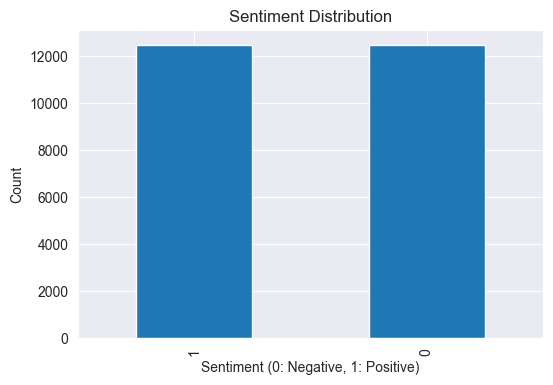

In [48]:
# the 'sentiment' column: 0 for negative and 1 for positive reviews
print("\n=== Sentiment Distribution ===")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment (0: Negative, 1: Positive)")
plt.ylabel("Count")
plt.show()

# Analysis of review text length


=== Review Length Descriptive Statistics ===
count    25000.000000
mean      1300.589160
std        984.488501
min         52.000000
25%        692.000000
50%        962.000000
75%       1580.000000
max      13584.000000
Name: review_length, dtype: float64


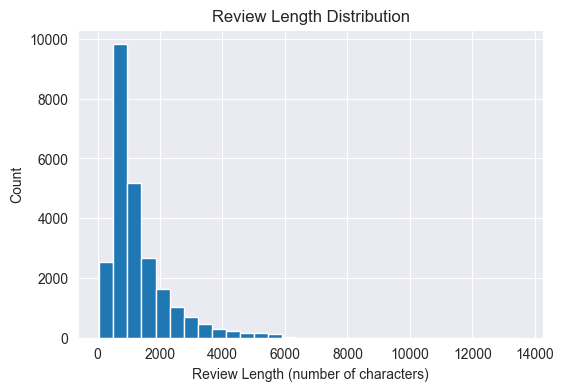

In [49]:
# Calculate the number of characters in each review
df['review_length'] = df['review'].apply(len)
print("\n=== Review Length Descriptive Statistics ===")
print(df['review_length'].describe())

plt.figure(figsize=(6, 4))
df['review_length'].hist(bins=30)
plt.title("Review Length Distribution")
plt.xlabel("Review Length (number of characters)")
plt.ylabel("Count")
plt.show()

This distribution suggests that most reviews are concise, with a moderate number of medium-length ones, and very few extremely long reviews. These insights can guide preprocessing steps such as truncation, padding, or sequence length tuning for deep learning models.

# Calculate emojis

In [74]:
from collections import Counter

def extract_emojis(text):
    return [char for char in text if char in emoji.EMOJI_DATA]

all_emojis = df['review'].apply(extract_emojis).sum()
emoji_counts = Counter(all_emojis)
print(emoji_counts.most_common(10))

[('®', 4)]


# TF-IDF vectorizer

In [64]:
def get_tfidf_vectorizer(text_series, use_stopwords=False, ngram_range=(1, 1)):
    stop_words = 'english' if use_stopwords else None

    vectorizer = TfidfVectorizer(
        max_features=20000,
        stop_words=stop_words,
        ngram_range=ngram_range,
        lowercase=True
    )

    X_tfidf = vectorizer.fit_transform(text_series)

    return vectorizer, X_tfidf

In [68]:
tfidf_vectorizer, tfidf_matrix = get_tfidf_vectorizer(df['review'], use_stopwords=True, ngram_range=(1, 2))

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print(tfidf_df.head())

    00  000  000 000   01        10  10 000  10 10  10 15  10 items  10 just  \
0  0.0  0.0      0.0  0.0  0.000000     0.0    0.0    0.0       0.0      0.0   
1  0.0  0.0      0.0  0.0  0.000000     0.0    0.0    0.0       0.0      0.0   
2  0.0  0.0      0.0  0.0  0.000000     0.0    0.0    0.0       0.0      0.0   
3  0.0  0.0      0.0  0.0  0.028684     0.0    0.0    0.0       0.0      0.0   
4  0.0  0.0      0.0  0.0  0.000000     0.0    0.0    0.0       0.0      0.0   

   ...  zombie movie  zombie movies  zombies  zone  zoo  zoom  zooms  zorro  \
0  ...           0.0            0.0      0.0   0.0  0.0   0.0    0.0    0.0   
1  ...           0.0            0.0      0.0   0.0  0.0   0.0    0.0    0.0   
2  ...           0.0            0.0      0.0   0.0  0.0   0.0    0.0    0.0   
3  ...           0.0            0.0      0.0   0.0  0.0   0.0    0.0    0.0   
4  ...           0.0            0.0      0.0   0.0  0.0   0.0    0.0    0.0   

    zu  zucker  
0  0.0     0.0  
1  0.0    

In [69]:
def collect_TF_common_words(dfs, labels, top_n=20):
    # List to hold all results from each DataFrame
    all_rows = []

    # Loop through each DataFrame with its corresponding label
    for df, label in zip(dfs, labels):
        #  Calculate the mean TF-IDF score for each word, then sort descending
        mean_df = df.mean().sort_values(ascending=False).head(top_n)

        temp_df = mean_df.reset_index()
        temp_df.columns = ['Word', 'Mean score']

        # Add the label as a column (to indicate where the data comes from)
        temp_df['Label'] = label

        all_rows.append(temp_df)

    result_df = pd.concat(all_rows, ignore_index=True)
    return result_df

In [70]:
mean_df = tfidf_df.mean().sort_values(ascending=False).head(20)

# . Convert the Series to a DataFrame for easier merging
temp_df = mean_df.reset_index()
temp_df.columns = ['Word', 'Mean score']

display(temp_df)

,Word,Mean score
0,movie,0.044877
1,film,0.038168
2,like,0.021725
3,just,0.020323
4,good,0.019185
5,story,0.016317
6,really,0.016196
7,time,0.016125
8,bad,0.015118
9,great,0.014092


In [77]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df['label'] = df['sentiment'].values

tfidf_pos = tfidf_df[tfidf_df['label'] == 1].drop(columns='label').mean().sort_values(ascending=False)
tfidf_neg = tfidf_df[tfidf_df['label'] == 0].drop(columns='label').mean().sort_values(ascending=False)

print(" Top words in positive reviews:")
print(tfidf_pos.head(20))

print("\n Top words in negative reviews:")
print(tfidf_neg.head(20))

 Top words in positive reviews:
movie         0.039113
film          0.039044
great         0.020162
good          0.019345
like          0.019162
story         0.018056
just          0.016112
time          0.015916
really        0.014988
love          0.014584
best          0.014126
people        0.013094
life          0.012887
movies        0.011979
think         0.011881
watch         0.011860
films         0.011544
seen          0.011480
way           0.011431
characters    0.011053
dtype: float64

 Top words in negative reviews:
movie     0.050641
film      0.037292
bad       0.024558
just      0.024535
like      0.024287
good      0.019024
really    0.017404
don       0.016432
time      0.016333
story     0.014579
plot      0.014514
acting    0.014448
people    0.014128
movies    0.014073
make      0.014070
watch     0.012417
worst     0.012164
better    0.012009
think     0.011846
did       0.011800
dtype: float64



Based on the computed mean TF-IDF scores, the most informative words across the corpus include terms like “movie”, “film”, “like”, “just”, “good”, and “bad”. These words consistently appear with relatively high importance across multiple documents.
This indicates that:
	•	These terms are not only frequent, but also carry strong discriminative power across the dataset.
	•	The extracted features reflect the typical vocabulary used in movie reviews.
	•	Words like “great”, “people”, “watch”, and “think” suggest common patterns of opinion and sentiment.

## TF-IDF + Knn

In [54]:
## Draw Confusion Matrix
def plot_confusion_and_classification_report(y_val, y_predict, labels=[0, 1], title="Confusion Matrix"):
    cm = confusion_matrix(y_val, y_predict, labels=labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

    # Classification Report
    print("\n=== Classification Report ===")
    print(classification_report(y_val, y_predict, target_names=[str(label) for label in labels]))

# TF-IDF KNN 

Best number of neighbors (k): 18
TFIDF KNN Accuracy: 0.7075


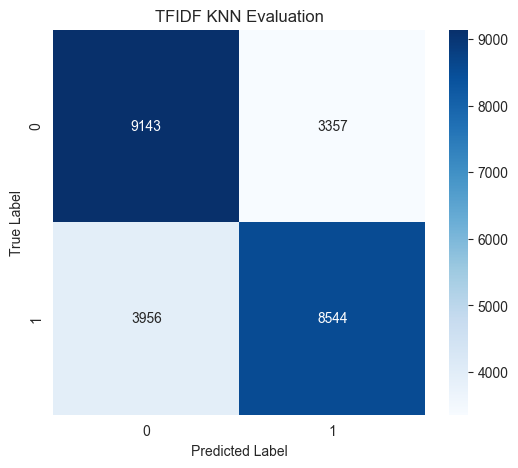


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.70      0.73      0.71     12500
           1       0.72      0.68      0.70     12500

    accuracy                           0.71     25000
   macro avg       0.71      0.71      0.71     25000
weighted avg       0.71      0.71      0.71     25000



In [55]:
accuracy_score_result={}
X = tfidf_matrix
y = df['sentiment']

## test Data
y_test = df_test['sentiment']
X_test = tfidf_vectorizer.transform(df_test['review'])

knn = KNeighborsClassifier(metric='cosine')


param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 18]
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)

best_knn = grid_search.best_estimator_
print(f"Best number of neighbors (k): {grid_search.best_params_['n_neighbors']}")

y_pred = best_knn.predict(X_test)

accuracy_score_knn = accuracy_score(y_test, y_pred)
print(f"TFIDF KNN Accuracy: {accuracy_score_knn:.4f}")
plot_confusion_and_classification_report(y_test, y_pred, labels=[0, 1], title="TFIDF KNN Evaluation")

accuracy_score_result.update({
    'TFIDF KNN Accuracy': accuracy_score_knn
})

We first note that k = 18 was selected via grid search with 5-fold cross-validation, since it maximized validation F1-score. On the test set, this configuration yields an overall accuracy of 70.75%.

The confusion matrix shows that out of 12,500 negative reviews, 9,143 were correctly classified and 3,357 were false positives. For the positive class, 8,544 out of 12,500 reviews were correctly identified, with 3,956 false negatives.

Converting these into recall rates, we get approximately 0.73 for negatives and 0.68 for positives, indicating the model is slightly better at catching negative sentiment.


## SentenceTransformer SBERT KNN

In [60]:
from sentence_transformers import SentenceTransformer

## Bert encode save
def load_or_generate_bert(df, filename, bert_model_name='all-mpnet-base-v2', batch_size=32):
    path = os.path.join("bert_embeddings", filename)
    if os.path.exists(path):
        print(f"Found existing path: {path}, loading...")
        print(f"Found existing file: {filename}, loading...")
        bert_features = np.load(path)
    else:
        print(f"File {filename} not found, generating embeddings...")
        bert_model = SentenceTransformer(bert_model_name)
        reviews = df['review'].tolist()

        bert_features = bert_model.encode(reviews, batch_size=batch_size, show_progress_bar=True)
        np.save(filename, bert_features)
        print(f" Saved combined embeddings to {filename}")

    return bert_features

In [61]:
## Load Bert embed
X_bert = load_or_generate_bert(df=df, filename="train_bert_embeddings.npy")
X_test_bert = load_or_generate_bert(df=df_test, filename="test_bert_embeddings.npy")

Found existing path: bert_embeddings/train_bert_embeddings.npy, loading...
Found existing file: train_bert_embeddings.npy, loading...
Found existing path: bert_embeddings/test_bert_embeddings.npy, loading...
Found existing file: test_bert_embeddings.npy, loading...


Best number of neighbors (k): 13
Bert KNN Accuracy: 0.8030


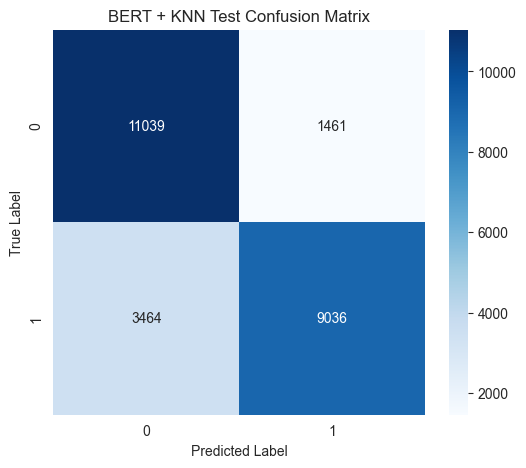


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.76      0.88      0.82     12500
           1       0.86      0.72      0.79     12500

    accuracy                           0.80     25000
   macro avg       0.81      0.80      0.80     25000
weighted avg       0.81      0.80      0.80     25000



In [62]:
y_test = df_test['sentiment']

knn = KNeighborsClassifier(n_neighbors=5, metric='cosine')


grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_bert, y)

best_knn = grid_search.best_estimator_
print(f"Best number of neighbors (k): {grid_search.best_params_['n_neighbors']}")


y_pred = grid_search.predict(X_test_bert)

accuracy_score_bert_knn = accuracy_score(y_test, y_pred)
print(f"Bert KNN Accuracy: {accuracy_score_bert_knn:.4f}")
plot_confusion_and_classification_report(y_test, y_pred, labels=[0, 1], title="BERT + KNN Test Confusion Matrix")
accuracy_score_result.update({
    'Bert KNN Accuracy': accuracy_score_bert_knn
})

We first note that k = 13 was selected via grid search with 5-fold cross-validation, since it maximized validation F1-score. On the test set, this configuration yields an overall accuracy of 80.30%.

The confusion matrix shows that out of 12,500 negative reviews, 11,039 were correctly classified and 1,461 were false positives. For the positive class, 9,036 out of 12,500 reviews were correctly identified, with 3,464 false negatives. Converting these into recall rates, we get approximately 0.88 for negatives and 0.72 for positives.

Compared to our TF-IDF pipeline, SBERT significantly reduces both false positives and false negatives, demonstrating the value of deep, context-aware embeddings.


### VADER BASELINE

Baseline Accuracy (VADER): 0.6934


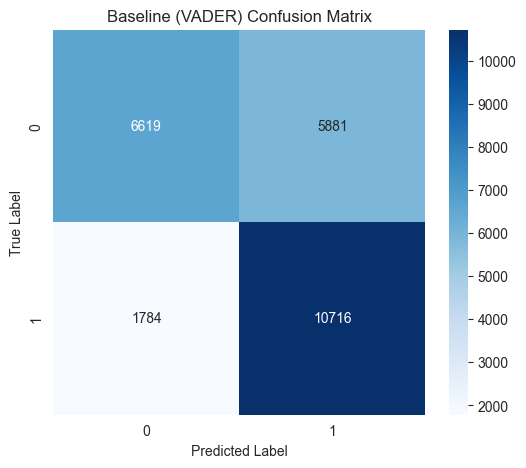


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.79      0.53      0.63     12500
           1       0.65      0.86      0.74     12500

    accuracy                           0.69     25000
   macro avg       0.72      0.69      0.68     25000
weighted avg       0.72      0.69      0.68     25000



In [86]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()
reviews = df['review']
y_true = df['sentiment']

y_pred = []
vader_scores = []
for review in reviews:
    vader_result = vader.polarity_scores(review)
    compound = vader_result['compound']
    vader_scores.append(compound)
    if compound >= 0:
        y_pred.append(1)
    else:
        y_pred.append(0)


accuracy_score_vader_baseline= accuracy_score(y_true, y_pred)
# print("\n=== VADER Baseline Evaluation ===")
# print(classification_report(y_true, y_pred))
print(f"Baseline Accuracy (VADER): {accuracy_score_vader_baseline:.4f}")
plot_confusion_and_classification_report(y_true, y_pred, labels=[0, 1], title="Baseline (VADER) Confusion Matrix")
accuracy_score_result.update({
    'Vader Baseline Accuracy': accuracy_score_vader_baseline
})

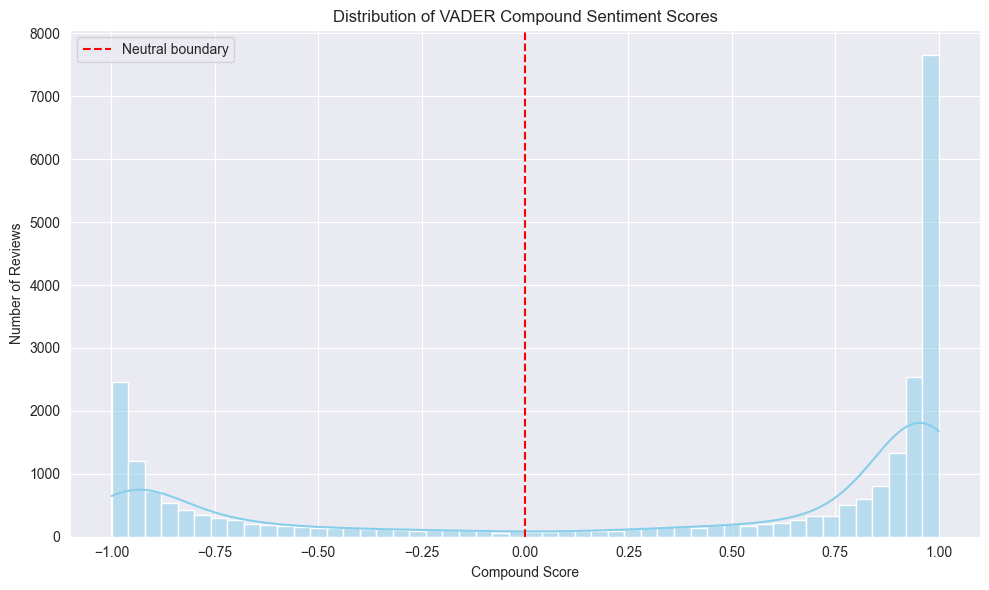

In [87]:
plt.figure(figsize=(10, 6))
sns.histplot(vader_scores, bins=50, kde=True, color='skyblue')
plt.title("Distribution of VADER Compound Sentiment Scores")
plt.xlabel("Compound Score")
plt.ylabel("Number of Reviews")
plt.axvline(0, color='red', linestyle='--', label='Neutral boundary')
plt.legend()
plt.tight_layout()
plt.show()

VADER shows high recall for the positive class (86%), indicating it’s good at identifying positive sentiment.
	•	However, it struggles to correctly classify negative reviews, as seen in the relatively low recall (53%) for the negative class.
	•	The precision-recall tradeoff reveals that while it’s sensitive to positive sentiment, it tends to over-predict positives, leading to many false positives.

Overall, VADER offers a decent starting point with ~69% accuracy but is limited by its rule-based nature.

# Model Accuracy Comparison

TFIDF KNN Accuracy Accuracy: 0.7075
Bert KNN Accuracy Accuracy: 0.8030
Vader Baseline Accuracy Accuracy: 0.6934


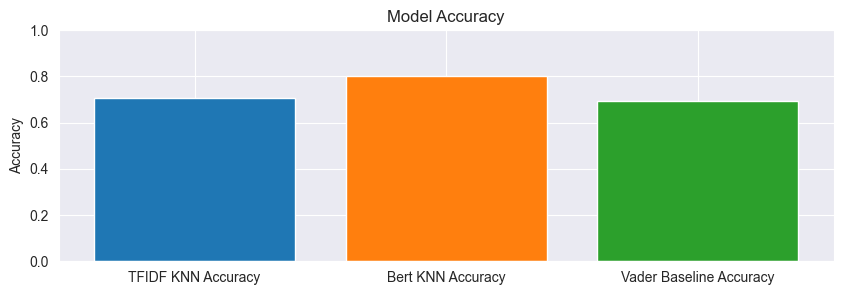

In [66]:
for name, score in accuracy_score_result.items():
    print(f"{name} Accuracy: {score:.4f}")
# Bar chart of models
plt.figure(figsize=(10,3))
plt.bar(accuracy_score_result.keys(), accuracy_score_result.values(), color=['C0','C1','C2','C3'][:len(accuracy_score_result)])
plt.ylim(0,1)
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.show()


First, the VADER baseline—a rule-based lexicon approach—achieved 69.34% accuracy.
Next, by adding TF-IDF vectorization and a KNN classifier, we improved slightly to 70.75%.
Finally, our SBERT + KNN pipeline, using all-mpnet-base-v2 embeddings, reached 80.30%—an over 9% boost compared to the TF-IDF pipeline.
This clear gain highlights the value of deep, context-aware embeddings for capturing nuanced sentiment in movie reviews.”


## ROC Curve and Precision Recall Curve

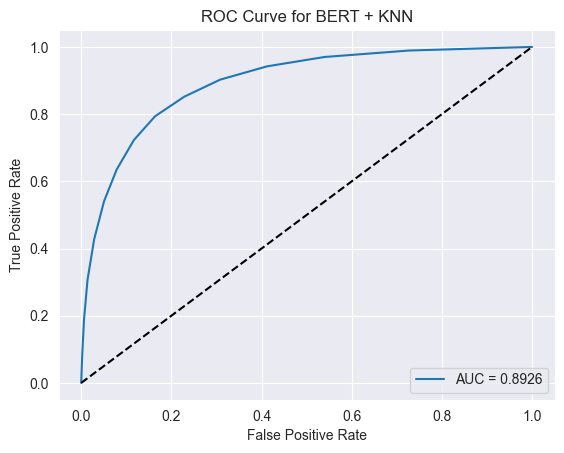

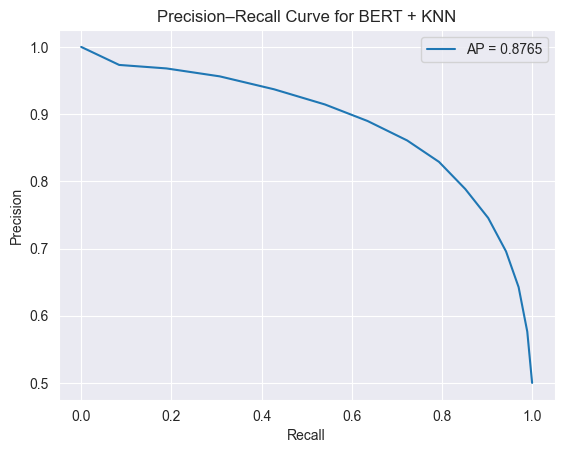

In [75]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_prob = best_knn.predict_proba(X_test_bert)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
# draw ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for BERT + KNN")
plt.legend(loc="lower right")
plt.show()

# cal Precision–Recall curve and  Average Precision
precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap_score = average_precision_score(y_test, y_prob)

# Precision–Recall
plt.figure()
plt.plot(recall, precision, label=f"AP = {ap_score:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve for BERT + KNN")
plt.legend(loc="upper right")
plt.show()

ROC Curve. The curve arches sharply toward the top-left, yielding an AUC of 0.8926. This shows our model can distinguish positive from negative reviews with high sensitivity—even at a false positive rate below 0.20, we achieve over 80% true positive rate.

Precision–Recall Curve. Here we plot precision versus recall, with an Average Precision of 0.8765. Notably, at 80% recall, precision remains above 85%, meaning most flagged positives are correct.

Together, these metrics confirm that deep, context-aware SBERT embeddings paired with a simple KNN classifier deliver robust and reliable sentiment detection.

